Imports

In [1]:
from parameters_U233 import *
import numpy as np
import matplotlib.pyplot as plt
from jitcdde import t
from msrDynamics.objects import Node, System
import pandas as pd
import sympy as sp
import math
pi = math.pi
from scipy.signal import find_peaks

In [2]:
f = 1e-1

MSRE = System()

# radiator
T_out_rc = Node(m = mn_rp, scp = mcp_rpn/mn_rp, W = W_rp, y0 = T0_rp)
T_out_air = Node(m = mn_rs, scp = mcp_rsn/mn_rs, W = W_rs, y0 = T0_rs)

# heat exchanger
T_hf1 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p1)
T_hf2 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p2)
T_hf3 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p3)
T_hf4 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p4)
T_ht1 = Node(m = m_tn, scp = scp_t, y0 = T0_t1)
T_ht2 = Node(m = m_tn, scp = scp_t, y0 = T0_t2)
T_hc1 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s1)
T_hc2 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s2)
T_hc3 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s3)
T_hc4 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s4)

# core 
n = Node(y0 = n_frac0)
C1 = Node(y0 = C0[0])
C2 = Node(y0 = C0[1])
C3 = Node(y0 = C0[2])
C4 = Node(y0 = C0[3])
C5 = Node(y0 = C0[4])
C6 = Node(y0 = C0[5])
rho = Node(y0 = 0.0)

# add reactivity input
r = 1e-5
def rho_insert(t):
        return r*sp.sin(f*t)

rho_ext = MSRE.add_input(rho_insert, T)

T_cg = Node(m = mcp_g1/scp_g, scp = scp_g, y0 = T0_g1)
T_cf1 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)
T_cf2 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f2)

MSRE.add_nodes([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
        T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

# dynamics 

# radiator
T_out_rc.set_dTdt_advective(source = T_hc4.y(t-tau_hx_r))
T_out_rc.set_dTdt_convective(source = [T_out_air.y()], hA = [hA_rpn])

T_out_air.set_dTdt_advective(source = Trs_in)
T_out_air.set_dTdt_convective(source = [T_out_rc.y()], hA = [hA_rsn])

# heat exchanger
T_hf1.set_dTdt_advective(source = T_cf2.y(t-tau_c_hx))
T_hf1.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

T_hf2.set_dTdt_advective(source = T_hf1.y())
T_hf2.dTdt_convective = T_hf1.dTdt_convective

T_hf3.set_dTdt_advective(source = T_hf2.y())
T_hf3.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

T_hf4.set_dTdt_advective(source = T_hf3.y())
# T_hf4.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])
T_hf4.dTdt_convective = T_hf3.dTdt_convective

# T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf2.y(),T_hc3.y(),T_hc4.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
# T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf4.y(),T_hc1.y(),T_hc2.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf1.y(),T_hc3.y(),T_hc3.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf3.y(),T_hc1.y(),T_hc1.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])

T_hc1.set_dTdt_advective(source = T_out_rc.y(t-tau_r_hx))
T_hc1.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

T_hc2.set_dTdt_advective(source = T_hc1.y())
T_hc2.dTdt_convective = T_hc1.dTdt_convective

T_hc3.set_dTdt_advective(source = T_hc2.y())
T_hc3.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

T_hc4.set_dTdt_advective(source = T_hc3.y())
T_hc4.dTdt_convective = T_hc3.dTdt_convective

# core
n.set_dndt(r = rho.y()+rho_ext, beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])
C1.set_dcdt(n.y(),beta[0],Lam,lam[0],tau_c,tau_l)
C2.set_dcdt(n.y(),beta[1],Lam,lam[1],tau_c,tau_l)
C3.set_dcdt(n.y(),beta[2],Lam,lam[2],tau_c,tau_l)
C4.set_dcdt(n.y(),beta[3],Lam,lam[3],tau_c,tau_l)
C5.set_dcdt(n.y(),beta[4],Lam,lam[4],tau_c,tau_l)
C6.set_dcdt(n.y(),beta[5],Lam,lam[5],tau_c,tau_l)

T_cg.set_dTdt_convective(source = [T_cf1.y()], hA = [hA_fg])
T_cg.set_dTdt_internal(source = n.y(), k = k_g*P)

T_cf1.set_dTdt_advective(source = T_hf4.y(t-tau_hx_c))
T_cf1.set_dTdt_convective(source = [T_cg.y()], hA = [k_1*hA_fg])
T_cf1.set_dTdt_internal(source = n.y(), k = k_f1*P)

T_cf2.set_dTdt_advective(source = T_cf1.y())
T_cf2.dTdt_convective = T_cf1.dTdt_convective
T_cf2.set_dTdt_internal(source = n.y(), k = k_f2*P)

rho.set_drdt(sources = [T_cf1.dydt(), T_cf2.dydt(), T_cg.dydt()], coeffs = [a_f/2,a_f/2,a_g])

MSRE.solve(T)

i_out = [i for i in range(len(T)) if T[i] >= 500]
n_out = np.array(n.y_out[i_out[0]:i_out[-1]+1])

# Assuming n_out is your steady-state output array and T is your time array

# Calculate Output Amplitude
peaks, _ = find_peaks(n_out)
troughs, _ = find_peaks(-n_out)
amplitude = (np.mean(n_out[peaks]) - np.mean(n_out[troughs]))/2

# Calculate Gain
input_amplitude = 1e-5  # as per your input function
gain = amplitude / input_amplitude

# Calculate Phase Shift
# Assuming you have a corresponding time array for your output
peak_times = T[i_out][peaks]
input_period = 2 * np.pi / f
t_peak = (input_period / 4)

# Calculate Phase Shift
phase_shift = ((peak_times[0] - t_peak) % input_period) / input_period * 360

# Convert phase shift to range [-180, 180]
if phase_shift > 180:
    phase_shift -= 360


Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target

In [8]:
# Calculate Phase Shift
phase_shift = ((peak_times[0] - t_peak) % input_period) / input_period * 360

# Convert phase shift to range [-180, 180]
#if phase_shift > 180:
#    phase_shift -= 360


In [10]:
phase_shift+=360

In [12]:
phase_shift%input_period

2.764063371928657

In [6]:
import numpy as np
test_sin = n.y_out[-1]+r*812.88*np.sin(f*T)

(500.0, 576.0)

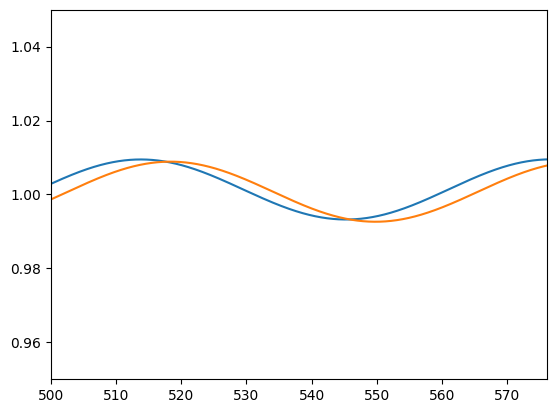

In [7]:
plt.plot(T,n.y_out)
plt.plot(T,test_sin)
plt.ylim([0.95,1.05])
plt.xlim([500, 576])